<a href="https://colab.research.google.com/github/onurburakozdemir/FIZ437E/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

Bu hücrede nöral ağ mimarisini tanımlıyoruz. Her bir resim için 784 elemanlı ve pixel değerlerini içeren bir tensör bulunur. 2 görünmeyen katmandan sonra 10 elemanlı bir tensör elde ederiz (class sayısı = 10)

In [2]:
model= nn.Sequential(
    nn.Linear(28*28,64), #Projection 28*28-->64
    nn.ReLU(), #Non-linear func
    nn.Linear(64,64), #Projection 64-->64
    nn.ReLU(), #Non-linear func (Learning)
    nn.Linear(64,10), #Projection 64-->10
)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64,10)
        # dropout prevents overfitting of data
        self.do = nn.Dropout(0.1)

    def forward(self,x):
        # hidden layer, with relu activation function
        h1 = nn.functional.relu(self.l1(x))
        # hidden layer, with relu activation function
        h2 =  nn.functional.relu(self.l2(h1))
        # dropout layer
        do = self.do(h2+h1)
        # output layer
        logits = self.l3(do)
        return logits # initialize the NN
model = ResNet().cuda()

Loss hesaplamak için cross-entrophy loss ve optimizasyon için SGD optimizasyonu kullandık. Pytorch'un cross entrophy loss fonksiyonu output layer'ına softmax fonksiyonunu uygular ve log loss hesaplar.

In [3]:
#Define optimiser 
params = model.parameters()
optimiser=optim.SGD(params, lr=1e-2)
#Define my loss
loss=nn.CrossEntropyLoss() 

MNIST setini indirip işlemeye hazır hale getiriyoruz ve verileri test/validation olarak ayırıyoruz.

In [5]:
#Train, Val split
train_data=datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train, val= random_split(train_data, [55000,5000])
train_loader = DataLoader(train, batch_size=32)
val_loader= DataLoader(val, batch_size=32)

Modeli eğitme ve geri yayılım.

In [6]:
nb_epochs=100
val_loss=list()
train_loss=list()
val_acc=list()
train_acc=list()

for epoch in range(nb_epochs):
  losses=list()
  accuracies=list()

  model.train() 

  for batch in train_loader:
    x,y= batch
    b=x.size(0)
    x=x.view(b, -1).cuda()
    l=model(x) 
    J=loss(l, y.cuda())
    model.zero_grad()
    J.backward()
    optimiser.step()
    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

  train_loss.append(torch.tensor(losses).mean())
  train_acc.append(torch.tensor(accuracies).mean())
  print(f'Epoch {epoch+1}', end=',') 
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end=',') 
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}')

  losses=list()
  accuracies=list()
  model.eval()

  for batch in val_loader:
    x,y= batch
    b=x.size(0)
    x=x.view(b, -1).cuda()
    with torch.no_grad():
        l=model(x)
    J=loss(l, y.cuda()) 
    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

  val_loss.append(torch.tensor(losses).mean())
  val_acc.append(torch.tensor(accuracies).mean())

  print(f'Epoch {epoch+1}', end=', ') 
  print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ') 
  print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1,training loss: 0.84,training accuracy: 0.79
Epoch 1, validation loss: 0.39, validation accuracy: 0.89
Epoch 2,training loss: 0.38,training accuracy: 0.89
Epoch 2, validation loss: 0.31, validation accuracy: 0.91
Epoch 3,training loss: 0.31,training accuracy: 0.91
Epoch 3, validation loss: 0.27, validation accuracy: 0.92
Epoch 4,training loss: 0.27,training accuracy: 0.92
Epoch 4, validation loss: 0.24, validation accuracy: 0.92
Epoch 5,training loss: 0.24,training accuracy: 0.93
Epoch 5, validation loss: 0.22, validation accuracy: 0.93
Epoch 6,training loss: 0.22,training accuracy: 0.94
Epoch 6, validation loss: 0.20, validation accuracy: 0.94
Epoch 7,training loss: 0.20,training accuracy: 0.94
Epoch 7, validation loss: 0.18, validation accuracy: 0.94
Epoch 8,training loss: 0.18,training accuracy: 0.95
Epoch 8, validation loss: 0.17, validation accuracy: 0.95
Epoch 9,training loss: 0.17,training accuracy: 0.95
Epoch 9, validation loss: 0.16, validation accuracy: 0.95
Epoch 10,t

Training ve validation loss grafiği

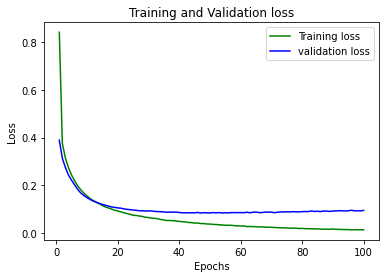

In [7]:
epochs = range(1,101)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training ve validation accuracy grafiği

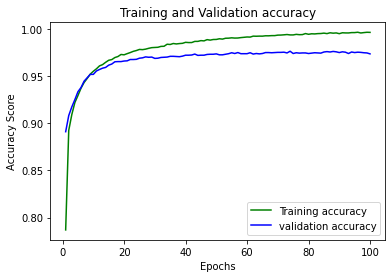

In [8]:
epochs = range(1,101)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

# SVM modeli ile karşılaştırmak gerekirse, önceki ödevde oluşturduğumuz tablodan yararlanabiliriz. 
 \begin{array}{|c|c|c|}
\hline 
Method  & MNIST & CIFAR \;10  \\
\hline
\text{LogRegression  without Regularization} & \%90.04 & \%37.24  \\
\hline
\text{LogRegression  with Regularization*} & \%76.12 & \%20.36  \\
\hline
\text{LogRegression  with Momentum**} & \%91.01 & \%35.73  \\
\hline
\text{LogRegression  with Nesterov Momentum} & \%91.32 & \%31.17  \\
\hline
\text{LogRegression  with ADAGRAD} & \%90.59 & \%35.97  \\
\hline
\text{LogRegression  with RMSProp} & \%87.87 & \%10.5  \\
\hline
\text{LogRegression  with ADAM} & \%92.06 & \%23.03  \\
\hline
\text{SVM without regularization} & \%90.94 & \%23.03  \\
\hline
\text{SVM with regularization*} & \%48.9 & \%12.14  \\
\hline
\text{SVM with RBF Kernel (Scikit Learn)} & \%97.02   \\
\hline
\end{array}

# Görülebilir ki MLP ile elde ettiğimiz accuracy (%97), ortalama bir SVM modeline kıyasla çok daha accurate.